Training Convolutional Neural Networks

Swapping the MLP for an CNN to classify MNIST images



In [ ]:
#%pip install watermark
#%pip install --upgrade pip
#%pip install torch
#%pip install lightning==2.1.1
#%pip install torchvision==0.20.1
#%pip install matplotlib
%pip install shared_utilities


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------- ----------- 5.5/7.8 MB 37.2 MB/s eta 0:00:01
   ---------------------------------------- 7.8/7.8 MB 25.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 30.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%load_ext watermark
%watermark -p torch,lightning --conda

torch    : 2.5.1
lightning: 2.1.1

conda environment: n/a



In [10]:
import lightning as L
import torch
import torchvision
import torch.nn.functional as F
import torchmetrics
from lightning.pytorch.loggers import CSVLogger
import matplotlib.pyplot as plt
import numpy as np

from shared_utilities import LightningModel, MnistDataModule, plot_loss_and_acc

ModuleNotFoundError: No module named 'shared_utilities'

In [ ]:
L.pytorch.seed_everything(123)

dm = MnistDataModule(batch_size=64)
dm.prepare_data()
dm.setup()

Seed set to 123


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 360kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1000)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.65MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



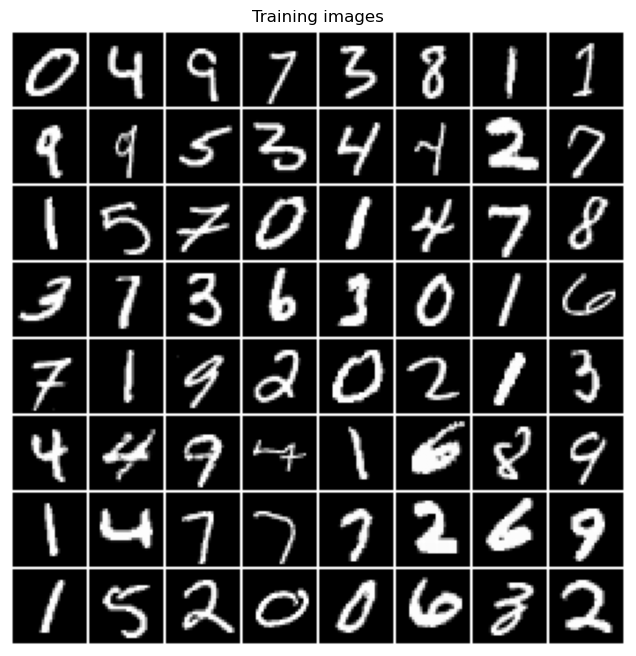

In [ ]:
for images, labels in dm.train_dataloader():  
    break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=1,
    pad_value=1.0,
    normalize=True),
    (1, 2, 0)))

plt.show()

In [ ]:
class PyTorchMLP(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()

        self.all_layers = torch.nn.Sequential(
            # 1st hidden layer
            torch.nn.Linear(num_features, 100),
            torch.nn.BatchNorm1d(100),
            torch.nn.ReLU(),
            
            # 2nd hidden layer
            torch.nn.Linear(100, 50),
            torch.nn.BatchNorm1d(50),
            torch.nn.ReLU(),
            
            # output layer
            torch.nn.Linear(50, num_classes),
        )

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        logits = self.all_layers(x)
        return logits

In [ ]:
class PyTorchCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        
        self.cnn_layers = torch.nn.Sequential(

            torch.nn.Conv2d(1, 3, kernel_size=5),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),
            
            torch.nn.Conv2d(3, 16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2),        
            
            torch.nn.Conv2d(16, 32, kernel_size=3),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2), 
        )
        
        self.fc_layers = torch.nn.Sequential(
            # hidden layer
            torch.nn.Linear(32, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),

            # output layer
            torch.nn.Linear(20, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        # print(x.shape)
        x = torch.flatten(x, start_dim=1)
        logits = self.fc_layers(x)
        return logits

In [ ]:
%%capture --no-display

L.seed_everything(123)
dm = MnistDataModule()

pytorch_model = PyTorchCNN(num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.1)

trainer = L.Trainer(
    max_epochs=10,
    accelerator="cpu",
    devices="auto",
    logger=CSVLogger(save_dir="logs/", name="my-model"),
    deterministic=True,
)

Seed set to 123
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model=lightning_model, datamodule=dm)


  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | PyTorchCNN         | 6.2 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
6.2 K     Trainable params
0         Non-trainable params
6.2 K     Total params
0.025     Total estimated model params size (MB)
22        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


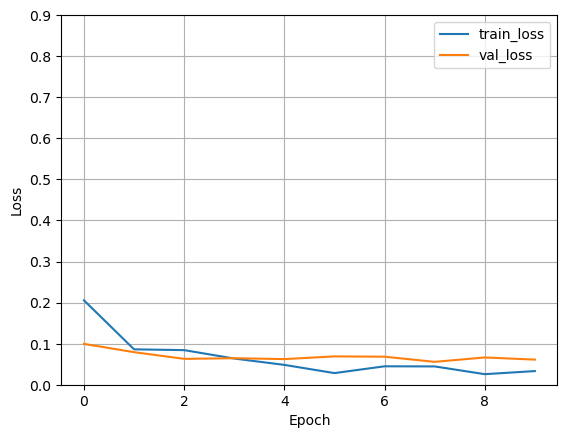

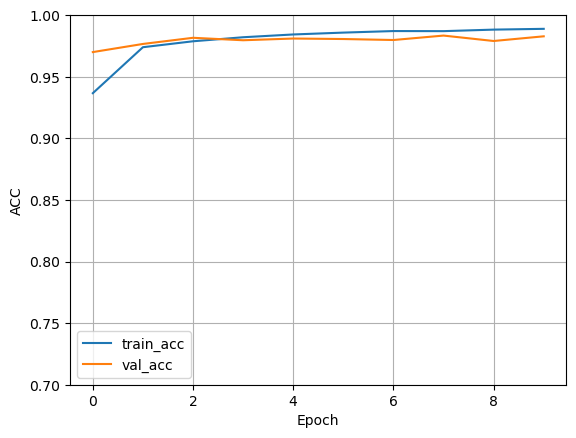

In [ ]:
plot_loss_and_acc(trainer.logger.log_dir)

In [ ]:
trainer.test(model=lightning_model, datamodule=dm)

/opt/anaconda3/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9861000180244446     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.9861000180244446}]